In [62]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from agent import model

# Example of Controlling LunarLander v2
Observation space:
[x, y, V_x, V_y, angle, angular velocity, left leg contact, right leg contact]

In [63]:
def reference_state(current_state):
    y_pos = current_state[1]
    if y_pos > 0.25:
        ref_state = [0, 0.25, 0, -0.5, 0, 0, 0, 0]
    else:
        ref_state = [0, 0, 0, -0.15, 0, 0, 0, 0]
    return ref_state

In [72]:
env = gym.make(
    "LunarLander-v2", continuous = True
)
init_condition = env.reset()
state_size = len(init_condition)
action_size = int(env.action_space.shape[0])

X, U, R, errors = [], [], [], []
t0 = 0
tn = 30
dt = 0.01
t = np.arange(t0, tn, dt)

# run single episode
for i in range(1,len(t)):
    action = [0,0.4]
    state, reward, done, _, _= env.step(action)
    X.append(state)
    U.append(action)
    R.append(reward)
    errors.append(np.abs(state - reference_state(state)))
    if done: 
        t = t[:i]
        break
action_size

2

## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


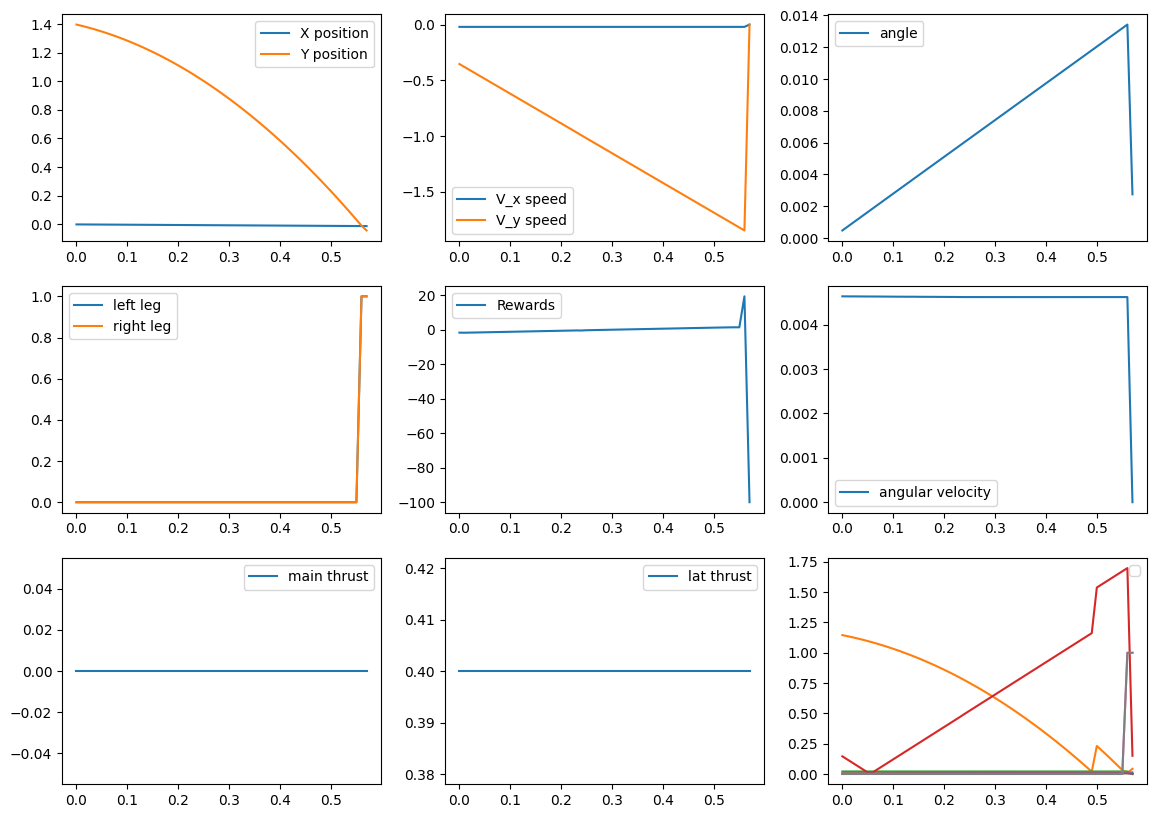

In [59]:
fig, axis = plt.subplots(3,3, figsize=(14,10))
axis[0, 0].plot(t, [i[0] for i in X], label="X position")
axis[0, 0].plot(t, [i[1] for i in X], label="Y position")
axis[0, 0].legend()

axis[0, 1].plot(t, [i[2] for i in X], label="V_x speed")
axis[0, 1].plot(t, [i[3] for i in X], label="V_y speed")
axis[0, 1].legend()

axis[0,2].plot(t, [i[4] for i in X], label="angle")
axis[0,2].legend()

axis[1,2].plot(t, [i[5] for i in X], label="angular velocity")
axis[1,2].legend()

axis[1,0].plot(t, [i[6] for i in X], label="left leg")
axis[1,0].plot(t, [i[7] for i in X], label="right leg")
axis[1,0].legend()

axis[1,1].plot(t, R, label="Rewards")
axis[1,1].legend()

axis[2,0].plot(t, [i[0] for i in U], label="main thrust")
axis[2,0].legend()
axis[2,1].plot(t, [i[1] for i in U], label="lat thrust")
axis[2,1].legend()

axis[2,2].plot(t, errors)
axis[2,2].legend()


# DHP LunarLander

In [73]:
env = gym.make(
    "LunarLander-v2", continuous = True
)
init_condition = env.reset()
state_size = len(init_condition)
action_size = int(env.action_space.shape[0])

X, U, R, errors = [], [], [], []
t0 = 0
tn = 30
dt = 0.01
t = np.arange(t0, tn, dt)

In [75]:
ac_kwargs = {
        # Arguments for all model types
        'state_size': state_size,
        'action_size': action_size,
        'predict_delta': False,
        # Neural Network specific args:
        'hidden_layer_size': [100, 100, 100],
        'activation': tf.nn.relu,
        # RLS specific args:
        'gamma': 0.9995,
        'covariance': 100,
        'constant': True,
        # LS specific args:
        'buffer_length': 10
}
ac_model = model.RecursiveLeastSquares(**ac_kwargs)


NameError: name 'DEFAULT_INCREMENTAL' is not defined